# Fig 1 - resistance in terms of mean and variance

## Overview:

N sprays most important thing for resistance

Effect of changes to initial distributions - variance and mean

(maths in appendix proves it)

And resistance increases with dose

Then can say simple things about resistance management, but yield and econ more complex (figs 2 onwards address)

FIG:
1. Mean of dist vs severity in diff cases (doses / sprays)
2. Mean of dist vs n sprays/dose
3. Variance vs change in following year or vs mean in year X

## Required data:

Uses `local/fig1_data.py`.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd
from scipy.stats import norm
from scipy import signal

import seaborn as sns
from math import floor

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import copy

from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
)

from poly2.utils import get_dist_mean, edge_values

from poly2.run import simulations_run, no_joblib_simulations_run
from poly2.config import Config

In [3]:
COLZ = sns.color_palette('muted').as_hex()

# Plot

## Data

In [276]:
df_in = (
    # pd.read_csv('../outputs/combined/fig1_no_dec_hg2.csv')
    # pd.read_csv('../outputs/combined/fig1_d240_hg95.csv')
    # pd.read_csv('../outputs/combined/fig1_dhg.csv')
    # pd.read_csv('../outputs/combined/fig1_no_dd_hg_dc.csv')
    # pd.read_csv('../outputs/combined/fig1_mutation_zero.csv')
    pd.read_csv('../outputs/combined/fig1_500_50.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

df_in.head(3)

,sprays,dose,year,sev,fung_mean,fung_var,total_sprays
0,1,1,0,NaN,0.002553,0.000056,0
1,1,1,1,3.012310,0.003615,0.000125,1
2,1,1,2,3.086163,0.005642,0.000292,2


In [277]:
df_use = (
    df_in
    .join(
    (
        df_in
        .groupby(['sprays', 'dose'])
        .diff()
        .loc[:, ['fung_mean']]
        .shift(-1)
        .rename(columns = {'fung_mean': 'mean_diff'})
    )
    )
)

df_use.head(18)

,sprays,dose,year,sev,fung_mean,fung_var,total_sprays,mean_diff
0,1,1,0,NaN,0.002553,0.000056,0,0.001062
1,1,1,1,3.012310,0.003615,0.000125,1,0.002028
2,1,1,2,3.086163,0.005642,0.000292,2,0.004005
3,1,1,3,3.208225,0.009648,0.000702,3,0.007965
4,1,1,4,3.414885,0.017613,0.001674,4,0.015234
5,1,1,5,3.765756,0.032847,0.003758,5,0.026333
6,1,1,6,4.338660,0.059180,0.007450,6,0.038836
7,1,1,7,5.184212,0.098016,0.012424,7,0.047985
8,1,1,8,6.251886,0.146000,0.017376,8,0.051388
9,1,1,9,7.389811,0.197389,0.021163,9,0.050492


## Fig fn

In [284]:
def fig1(df):
    
    fig = make_subplots(
        rows=3,
        cols=1,
        # shared_xaxes=True,
        # horizontal_spacing=0.33,
        vertical_spacing=0.15,
    )
    
    # len 10
    # colors1 = px.colors.sequential.Viridis
    # colors2 = px.colors.sequential.Agsunset
    # colors3 = px.colors.sequential.Cividis
    
    # cols = {1: colors1, 2: colors2, 3: colors3}
    
    cols = ['red', 'blue', 'black']
    # dashes = ['dot', 'solid']
    
    for spray, color in zip([1,2,3], cols):
        by_spray = df.loc[df.sprays==spray]
        
        # for dose, dash in zip(by_spray.dose.unique(), dashes):
        for dose in by_spray.dose.unique():
            
            dash = 'solid'
            
            by_spray_and_dose = by_spray.loc[lambda dd: dd.dose==dose]
            
            plural = 's' if spray!=1 else ''
            
            name_this_dose = f'{spray} spray{plural}'
            
            
            if spray==2:
                t_3 = go.Scatter(
                    x=by_spray_and_dose.total_sprays,
                    y=by_spray_and_dose.fung_mean,
                    mode='lines+markers',
                    name=name_this_dose,
                    marker=dict(color=color, size=4),
                    line=dict(color=color, dash=dash),
                    # opacity=0.5,
                    showlegend=False
                )

                fig.add_trace(t_3, row=3, col=1)
            
            
            
            
            if dose!=1:
                continue
            
            
            t_1 = go.Scatter(
                    x=by_spray_and_dose.fung_mean,
                    y=by_spray_and_dose.sev,
                    mode='lines+markers',
                    name=name_this_dose,
                    marker=dict(color=color, size=4),
                    line=dict(color=color, dash=dash),
                )

            fig.add_trace(t_1, row=1, col=1)
            
            
            
            t_2 = go.Scatter(
                x=by_spray_and_dose.total_sprays,
                y=by_spray_and_dose.fung_mean,
                mode='lines+markers',
                name=name_this_dose,
                marker=dict(color=color, size=4),
                line=dict(color=color, dash=dash),
                # opacity=0.5,
                showlegend=False
            )
    
            fig.add_trace(t_2, row=2, col=1)
        
#             t_3 = go.Scatter(
#                 x=by_spray_and_dose.fung_var,
#                 y=by_spray_and_dose.mean_diff,
#                 mode='lines+markers',
#                 name=name_this_dose,
#                 marker=dict(color=color, size=4),
#                 line=dict(color=color, dash=dash),
#                 opacity=0.5,
#                 showlegend=False
#             )
    
#             fig.add_trace(t_3, row=3, col=1)
            
            
    
    
    
    
    
    fig.update_layout(standard_layout(True, height=800))
    
    fig.update_layout(legend=dict(x=0, y=1.18, orientation='h', font=dict(size=12)))
    
    corners = corner_annotations_colwise(
        3, 1,
        1.05, 0,
        0.38, 0
    )
    
    fig.update_layout(annotations=corners)
    
    # X axis    
    
    # xrange = [0,15]
    
    fig.update_xaxes(title_text='Trait mean',
                     row=1, col=1,
                     # rangemode='tozero',
                     # range=[-0.01, 1.01],
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=2, col=1,
                     # range=xrange,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=3, col=1,
                     # range=xrange,
                     showgrid=False)
    
    # fig.update_xaxes(title_text='Trait variance',
    #                  row=3, col=1,
    #                  # range=xrange,
    #                  showgrid=False)
    
    
    # Y axis    
    fig.update_yaxes(title_text='Disease severity (%)',
                     # type='log',
                     row=1, col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=2, col=1,
                         showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=3, col=1,
                         showgrid=False)
    
    # fig.update_yaxes(title_text='Change in trait mean',
    #                      row=3, col=1,
    #                      showgrid=False)

    return fig

## FIG

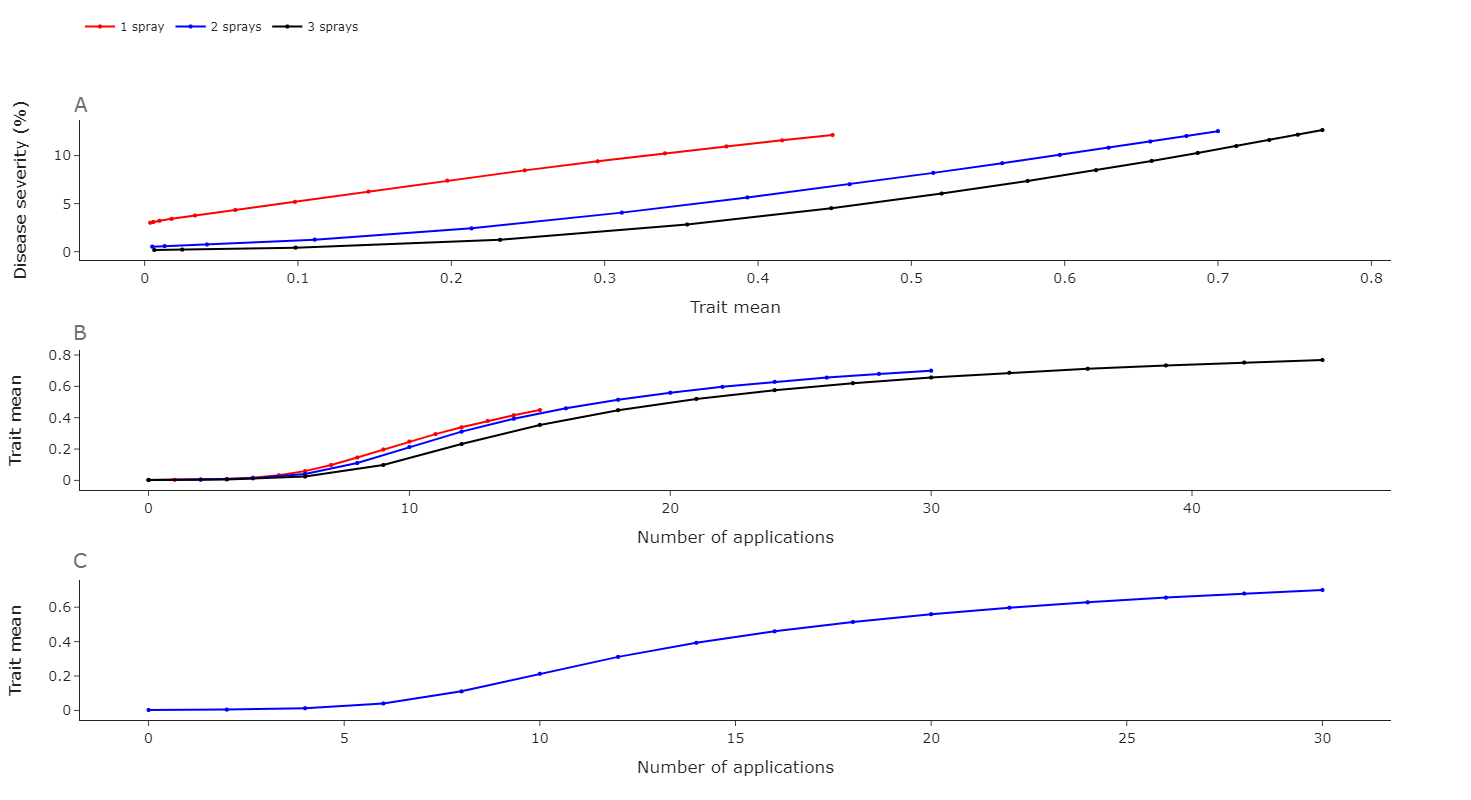

In [285]:
f = fig1(df_use)

f.show()

In [230]:
# f.write_image('../figures/rough/maths_no_density_dependence_host_growth_or_fung_decay.png')

More applications gives slightly slower relative increase:

- perhaps due to mutation having less of an effect? i.e. fewer generations so less mutation?
- something to do with chemical decay / density dependence?

High dose / N applications:

- reduced mutation
- increased selection on existing variation or variants that do arise via mutation (but not per spray increased?)

In [11]:
f.write_image('../figures/paper/fig1.png')

# Testing

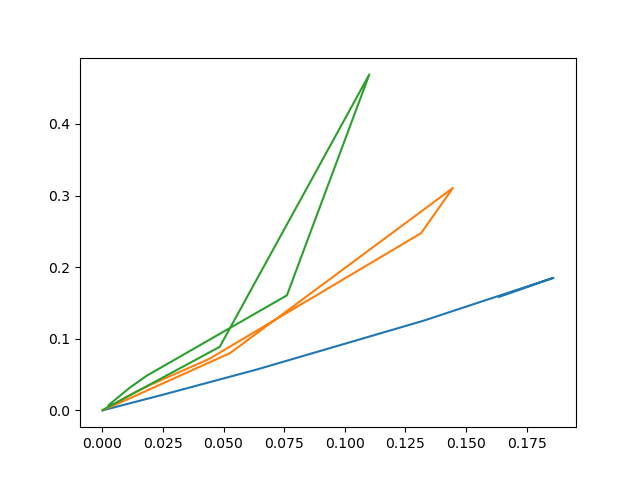

In [257]:
f, ax = plt.subplots()


for ii in range(1,4):
    df2 = (
        df_use
        .loc[lambda x: ((x.sprays==ii) & (x.dose==1))]
        .assign(middle_var = lambda df: df.fung_var + df.fung_var.shift(-1))
    )

    # ax.plot(df2.fung_var, df2.mean_diff)
    ax.plot(df2.middle_var, df2.mean_diff)